# Imports

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# stdlib
import os
import shutil
import sqlite3

# 3rd party
import ipyparallel as ipp
import ipyvolume as ipv
import ipywidgets as ipw
import numpy as np
from scipy.optimize import minimize
import sympy as sp
import matplotlib.pyplot as plt

# local
import convergence as conv
import kelp_analyze
import kelp_compute
import mms
import discrete_plot
import run_utils as ru

In [37]:
sp.init_printing()
%matplotlib inline

---

# User-function definitions

In [38]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [5]:
def linear_vsf(delta):
    """Defined on [-1, 1]."""
    return (delta+1)/(4*sp.pi)

In [6]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        * (2+sp.sin(phi))
    )

In [7]:
def exp_L(x, y, z, theta, phi, b, alpha, gamma):
    return sp.exp(-2*z) - sp.exp(2*b*gamma)

In [8]:
def expb_L(x, y, z, theta, phi, b, alpha, gamma):
    return gamma*sp.exp(-2*b*z) - z*sp.exp(-2*b*gamma)

In [10]:
def expb15_L(x, y, z, theta, phi, b, alpha, gamma):
    return gamma**1.5*sp.exp(-2*b*z) - z**1.5*sp.exp(-2*b*gamma)

In [11]:
def down_L(x, y, z, theta, phi, b, alpha, gamma):
    return sp.Piecewise((sp.exp(-z), phi<sp.pi/2), (0, True))

In [12]:
def zero_L(x, y, z, theta, phi, b, alpha, gamma):
    return 0 * sp.Symbol('x')

In [13]:
def uniform_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha

In [14]:
def unisinb_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha*(1+sp.sin(b))

In [15]:
def tanh_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha * (2+sp.sin(z/10)) * sp.tanh((gamma-z)/10) * z * (2+sp.sin(4*sp.pi*x/alpha) + sp.sin(4*sp.pi*y/alpha)) / 5

In [16]:
def tanh_b_L(x, y, z, theta, phi, b, alpha, gamma):
    """
    alpha = rope_spacing
    gamma = zmax
    """
    return (
        alpha * (z-gamma+sp.tanh((1+b)*(gamma-z)) / sp.tanh((1+b)*gamma))
        * (1+z*(sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha)))
        *(1+sp.sin(theta+phi))
    )

In [17]:
def prod_a(x, y, z, alpha, gamma):
    return 1 + (3+sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha))*(1+sp.tanh(z-gamma))

In [18]:
def uniform_a(x, y, z, alpha, gamma):
    return 0.2

In [19]:
def inv_a(x, y, z, alpha, gamma):
    return 1/tanh_L(x, y, z, 0, 0, 0, alpha, gamma)

### Decide here which functions to use.

In [20]:
sol_func = expb15_L
abs_func = uniform_a
vsf_func = uniform_vsf

---

# Symbolic Calculations

## Calculate source & BC

In [21]:
b = sp.var('b')
params = sp.var('alpha, gamma')

source_expr = mms.calculate_source(sol_func, b, abs_func, vsf_func, params)
bc_expr = mms.calculate_bc(sol_func, b, params)

# Evaluate other expressions as well for consistency
sol_expr = sol_func(*mms.space, *mms.angle, b, *params)
abs_expr = abs_func(*mms.space, *params)
vsf_expr = vsf_func(mms.delta)

## Specify parameter values

In [22]:
# Domain size
rope_spacing = 1
zmax = 1
b = 0.5

param_vals = {
    'alpha': rope_spacing,
    'gamma': zmax,
    'b': b
}

## Generate symbolic and numerical functions

In [23]:
# Generate symbolic functions
source_sym = mms.symify(source_expr, *mms.space, *mms.angle, **param_vals)
abs_sym = mms.symify(abs_expr, *mms.space, **param_vals)
bc_sym = mms.symify(bc_expr, *mms.angle, **param_vals)
vsf_sym = mms.symify(vsf_expr, mms.delta, **param_vals)
sol_sym = mms.symify(sol_expr, *mms.space, *mms.angle, **param_vals)

# Generate numerical functions
abs_func_N = mms.sym_to_num(abs_sym, *mms.space)
source_func_N = mms.sym_to_num(source_sym, *mms.space, *mms.angle)
bc_func_N = mms.sym_to_num(bc_sym, *mms.angle)
vsf_func_N = mms.sym_to_num(vsf_sym, mms.delta)
sol_func_N = mms.sym_to_num(sol_sym, *mms.space, *mms.angle)

## Problem Summary

Solution



Absorption Coefficient



VSF


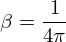

Boundary Condition



Source


In [24]:
print("Solution")
mms.display_eq('L', sol_expr)
print()

print("Absorption Coefficient")
mms.display_eq('a', abs_expr)
print()

print("VSF")
mms.display_eq('beta', vsf_expr)

print("Boundary Condition")
mms.display_eq('L_0', bc_expr)
print()

print("Source")
mms.display_eq('sigma', source_expr)
print()

---

# Symbolic Analysis

## Check solution constraints

- Everything is periodic in x, y
- Absorption coefficient is positive
- Boundary condition depends only on angle
- No upwelling light from below
- Properly normalized VSF

In [25]:
# Check bottom BC
print('bottom:', sp.expand(sol_expr.subs('z',sp.Symbol('gamma'))) == 0)

# Check periodicity
smax = sp.Symbol('alpha')/2
smin = -smax
print('x:', sp.expand(sol_expr.subs('x',smax) - sol_expr.subs('x',smin)) == 0)
print('y:', sp.expand(sol_expr.subs('y',smax) - sol_expr.subs('y',smin)) == 0)

# Check VSF normalization (Should be 1 over whole sphere, or 1/(2pi) on [-1, 1].)
print(
    "VSF:",
    1 == sp.expand(
        mms.sphere_integral(
            vsf_expr.subs(
                'Delta', 
                mms.dot(
                    mms.vec_om, 
                    mms.vec_omp)
            ), 
            angle=mms.angle
        )
    )
)

bottom: True
x: True
y: True
VSF: True


## Check source term

If source term appears nonzero, try substituting parameters,
then plugging in analytical solution.

The result should be 0.

In [26]:
diff = mms.check_sol(sol_sym, b, abs_sym, vsf_sym, source_sym)
diff

In [27]:
num_diff = sp.lambdify(
    (*mms.space, *mms.angle),
    diff,
    modules=("numpy",)
)

In [28]:
# Check numerical max on grid in case of numerical error in above expression
np.max(num_diff(*mms.gen_grid(10, 10, 10, 10, 1, 1)))


## Examine solution dervatives

In [29]:
conv.max_derivs(sol_expr, rope_spacing, zmax, do_space=True, do_angle=True, **param_vals)

{'x': 0, 'y': 0, 'z': 1.0746199401983112, 'theta': 0, 'phi': 0}

In [30]:
conv.max_derivs(abs_expr, rope_spacing, zmax, do_space=True, do_angle=False, **param_vals)

{'x': 0, 'y': 0, 'z': 0}

In [31]:
conv.max_derivs(source_expr, rope_spacing, zmax, do_space=True, do_angle=True, **param_vals)

{'x': 0,
 'y': 0,
 'z': 0.4975997205149192,
 'theta': 0,
 'phi': 1.0582940486488122}

---

# FD Verification

## IPyParallel Setup

In [32]:
#remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

[1]


/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [33]:
ipc.queue_status()

{'unassigned': 0,
 0: {'queue': 0, 'completed': 0, 'tasks': 0},
 1: {'queue': 0, 'completed': 0, 'tasks': 0}}

In [34]:
print("hi")

hi


## Single Space

### Compute

In [38]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

na = 6

study_name = 'verify_1dtest_ss_32x{}'.format(na)
study_dir = os.path.join(base_dir, study_name)

ns_list = [4, 8, 16, 32]
#ns_list = [4, 8, 12, 16, 20]

ntheta = na
nphi = na

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 0
fd_flag = False
num_threads = 4

b = 0
param_vals['b'] = 0

combine_thread, gs_fut = kelp_compute.verify_single_space_compute(
    study_name, 
    ns_list, ntheta, nphi, 
    rope_spacing, zmax, b, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    num_scatters, num_threads, fd_flag,
    param_vals, base_dir=base_dir)

Appending existing study directory.
Running grid ( 4, 4, 6, 6)
Running grid ( 8, 8, 6, 6)
Running grid (16,16, 6, 6)
Running grid (32,32, 6, 6)
Reading existing runs.
Finished reading existing runs.
Calling solve_rte_with_callbacks(4, 4, 6, 6, 1, 1, 0, gamma*exp(-2*b*z) - z*exp(-2*b*gamma), 0.2, -b*(gamma*exp(-2*b*z) - z*exp(-2*b*gamma)) + (b + 0.2)*(gamma*exp(-2*b*z) - z*exp(-2*b*gamma)) + (-2*b*gamma*exp(-2*b*z) - exp(-2*b*gamma))*cos(phi), gamma, 1/(4*pi), {'alpha': 1, 'gamma': 1, 'b': 0}, 0, 4, False, study_dir='/home/oliver/academic/research/kelp-results/verify_1dtest_ss_32x6', study_name='verify_1dtest_ss_32x6')

Calling solve_rte_with_callbacks(8, 8, 6, 6, 1, 1, 0, gamma*exp(-2*b*z) - z*exp(-2*b*gamma), 0.2, -b*(gamma*exp(-2*b*z) - z*exp(-2*b*gamma)) + (b + 0.2)*(gamma*exp(-2*b*z) - z*exp(-2*b*gamma)) + (-2*b*gamma*exp(-2*b*z) - exp(-2*b*gamma))*cos(phi), gamma, 1/(4*pi), {'alpha': 1, 'gamma': 1, 'b': 0}, 0, 4, False, study_dir='/home/oliver/academic/research/kelp-results/verify

/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Opening combined db: /home/oliver/academic/research/kelp-results/verify_1dtest_ss_32x6/verify_1dtest_ss_32x6.db
Connected.
Opening combined db: /home/oliver/academic/research/kelp-results/verify_1dtest_ss_32x6/verify_1dtest_ss_32x6.db
Connected.


### Plot

In [ ]:
study_name = 'verify_ss_noscat_nofd_32x6'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

err_dict = {}
for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
        nz=ns,
    )

    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]

    err = norm(rad - true_rad)
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

conv.plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr))+.1, max(np.log(res_arr)), 
    xlabel='ds', ylabel='err'
)

## Multi-dimensional FD

### Compute

### Plot

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
max_res_list = list(map(
    max,
    dim_resolutions
))
max_res_dict = {
    name: max_res
    for name, max_res in zip(dim_names, max_res_list)
}
dim_dict = dict(zip(dim_names, dim_resolutions))

# Loop over dimensions
for dim_num, dim_name in enumerate(dim_names):
    # List of resolutions in the current dimension
    current_dim = dim_dict[dim_name]
    
    print(dim_name)
    err_dict = {}
    for n in current_dim:
        all_dims = {**max_res_dict, **{dim_name: n}}
        results_list = kelp_analyze.query_results(
            conn, study_name, 
            **all_dims
        )

        rad = results_list[0]['rad'][:]
        true_rad = results_list[0]['true_rad'][:]

        err = norm(rad - true_rad)
        err_dict[n] = err

    res_arr = rope_spacing / np.array(current_dim)
    err_arr = np.array([err_dict[n] for n in current_dim])

    conv.plot_lin_fit(
        np.log(res_arr), np.log(err_arr), 
        min(np.log(res_arr)), max(np.log(res_arr)), 
        xlabel='d'+dim_name[1:], ylabel='err'
    )

# Asymptotics Verification

## Sourceless

### 1D, Uniform abs.

#### Compute

In [ ]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

nz = 20

nz_list = [nz]

study_name = 'verify_asym_noscat_1d_uniform_abs_{}'.format(nz)
study_dir = os.path.join(base_dir, study_name)

noscat_bc_expr = 1.0
noscat_abs_expr = 1.0

ntheta = na
nphi = na

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.verify_asym_noscat_1d_compute(
    study_name, 
    nz_list,
    rope_spacing, zmax, 
    noscat_abs_expr, noscat_bc_expr,
    param_vals, base_dir=base_dir
)

#### Plot

In [ ]:
study_name = 'verify_asym_noscat_1d_uniform_abs_20'
study_dir = os.path.join(base_dir, study_name)

In [ ]:
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

results_list = kelp_analyze.query_results(
    conn, study_name,
)

results = results_list[0]
rad = results['rad'][:][:,:,:,0]
true_rad = results['true_rad'][:][:,:,:,0]

avg_rad = np.mean(rad, axis=(0, 1))
avg_true_rad = np.mean(true_rad, axis=(0, 1))

err = norm(rad - true_rad)

print("err = {:.2f}".format(err))


_, _, z, _, _ = mms.gen_grid(
    *map(
        lambda x: int(results[x][:].data),
        ('ns', 'nz', 'ntheta', 'nphi', 'rope_spacing', 'zmax')
    )
)

z = z[0,0,:,0]

plt.plot(z, avg_rad, 'o-', label='approx.')
plt.plot(z, avg_true_rad, 'o-', label='true')
plt.legend()
plt.xlabel('z')
plt.ylabel('avg rad')

### 1D, Non-uniform abs., increase nz

#### Compute

In [ ]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

nz_list = [4, 8, 12, 20, 40, 100]

study_name = 'verify_asym_noscat_1d_variable_abs_{}'.format(max(nz_list))
study_dir = os.path.join(base_dir, study_name)

noscat_bc_expr = 1.0
noscat_abs_expr = 2 + sp.sin(10*sp.Symbol('z'))

ntheta = na
nphi = na

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.verify_asym_noscat_1d_compute(
    study_name, 
    nz_list,
    rope_spacing, zmax, 
    noscat_abs_expr, noscat_bc_expr,
    param_vals, base_dir=base_dir
)

#### Plot

In [ ]:
study_name = 'verify_asym_noscat_1d_variable_abs_100'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

nz_list = dim_dict['nz']

err_dict = {}
for nz in nz_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        nz=nz,
    )

    rad = results_list[0]['rad'][:,:,:,0]
    true_rad = results_list[0]['true_rad'][:,:,:,0]

    err = norm(rad - true_rad)
    err_dict[nz] = err

res_arr = zmax / np.array(nz_list)
err_arr = np.array([err_dict[nz] for nz in nz_list])

conv.plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='log10 dz', ylabel='log10 err'
)


## Full MMS

### 3D, noscat., const. abs., source

#### Compute

In [ ]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

ns = 20
nz = 20
na = 6

study_name = 'verify_ss_noscat_const_abs_scat_{}x{}x{}'.format(ns, nz, na)
study_dir = os.path.join(base_dir, study_name)

ns_list = [4, 8, 16, 32]
#ns_list = [4, 8, 12, 16, 20]

ntheta = na
nphi = na

sigma = 1
a = 1

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

b = 0
param_vals['b'] = 0

combine_thread, gs_fut = kelp_compute.verify_asym_noscat_const_abs_and_source_compute(
    study_name, 
    ns, nz, ntheta, nphi, 
    a, sigma,
    rope_spacing, zmax,
    param_vals, base_dir=base_dir
)

#### Plot

In [ ]:
study_name = 'verify_ss_noscat_const_abs_scat_20x20x6'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

##### rad. vs. depth

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

plt.figure(1)
plt.figure(2)

results_list = kelp_analyze.query_results(
    conn, study_name,
    ns=ns,
)

results = results_list[0]
nomega = results['nomega'][:]

p = 0 #nomega - 1

rad = results['rad'][:][:,:,:,p]
true_rad = results['true_rad'][:][:,:,:,p]

avg_rad = np.mean(rad, axis=(0, 1))
avg_true_rad = np.mean(true_rad, axis=(0, 1))

err = norm(rad - true_rad)

print("err = {:.2f}".format(err))


_, _, z, _, _ = mms.gen_grid(
    *map(
        lambda x: int(results[x][:].data),
        ('ns', 'nz', 'ntheta', 'nphi', 'rope_spacing', 'zmax')
    )
)

z = z[0,0,:,0]

plt.figure(1)
plt.plot(z, avg_rad, 'o-', label='ns={}'.format(ns))

plt.figure(2)
plt.semilogy(z, np.abs(avg_rad - avg_true_rad), 'o-', label='ns={}'.format(ns))

plt.figure(1)
plt.plot(z, avg_true_rad, 'o-', label='true')
plt.legend()
plt.xlabel('z')
plt.ylabel('avg rad')

plt.figure(2)
plt.legend()
plt.xlabel('z')
plt.ylabel('|avg rad - true|')

### 3D, ss. conv., noscat., no bc., sym. soln.

#### Compute

In [ ]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

na = 8

study_name = 'verify_ss_asym_noscat_nobc_const_abs_pp_source_32x{}'.format(na)
study_dir = os.path.join(base_dir, study_name)

#ns_list = [10]
ns_list = [4, 8, 16, 32]
#ns_list = [4, 8, 12, 16, 20]

ntheta = na
nphi = na

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 0
fd_flag = False

param_vals['b'] = 0
bc_expr = 0

asym_abs_expr = 1 #+ sum(mms.space)
asym_source_expr = 1 + sp.sin(2*sp.pi * sp.Symbol('z')) #+ sum((*mms.space, *mms.angle))

combine_thread, gs_fut = kelp_compute.verify_ss_asym_noscat_compute(
    study_name, 
    ns_list, ntheta, nphi, 
    asym_abs_expr, asym_source_expr, bc_expr,
    rope_spacing, zmax,
    param_vals, base_dir=base_dir
)

#### Plot

In [ ]:
study_name = 'verify_ss_asym_noscat_nobc_const_abs_pp_source_32x8'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

##### rad. vs. depth

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

plt.figure(1)
plt.figure(2)

for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
    )
    results = results_list[0]
    
    nomega = results['nomega'][:]
    
    p = nomega - 1

    rad = results['rad'][:][:,:,:,p]
    true_rad = results['true_rad'][:][:,:,:,p]

    avg_rad = np.mean(rad, axis=(0, 1))
    avg_true_rad = np.mean(true_rad, axis=(0, 1))

    err = norm(rad - true_rad)

    print("err = {:.2f}".format(err))


    _, _, z, _, _ = mms.gen_grid(
        *map(
            lambda x: int(results[x][:].data),
            ('ns', 'nz', 'ntheta', 'nphi', 'rope_spacing', 'zmax')
        )
    )

    z = z[0,0,:,0]

    plt.figure(1)
    plt.plot(z, avg_rad, 'o-', label='ns={}'.format(ns))
    
    plt.figure(2)
    plt.semilogy(z, np.abs(avg_rad - avg_true_rad), 'o-', label='ns={}'.format(ns))

plt.figure(1)
plt.plot(z, avg_true_rad, 'o-', label='true')
plt.legend()
plt.xlabel('z')
plt.ylabel('avg rad')

plt.figure(2)
plt.legend()
plt.xlabel('z')
plt.ylabel('|avg rad - true|')

##### err. vs. ds

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

err_dict = {}
for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
    )

    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]

    err = norm(rad - true_rad)
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

conv.plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='log10 ds', ylabel='log10 err'
)

### 3D, ss. conv., noscat.

#### Compute

In [ ]:
print(gs_fut[0].stdout)

In [ ]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

na = 6

study_name = 'verify_ss_noscat_nofd_32x{}'.format(na)
study_dir = os.path.join(base_dir, study_name)

ns_list = [4, 8, 16, 32]
#ns_list = [4, 8, 12, 16, 20]

ntheta = na
nphi = na

# TODO: Don't actually delete results
# shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 0
fd_flag = False

b = 0
param_vals['b'] = 0

combine_thread, gs_fut = kelp_compute.verify_single_space_compute(
    study_name, 
    ns_list, ntheta, nphi, 
    rope_spacing, zmax, b, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    num_scatters, fd_flag,
    param_vals, base_dir=base_dir)

#### Plot

In [ ]:
study_name = 'verify_ss_noscat_nofd_32x6'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

##### rad. vs. depth

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

plt.figure(1)
plt.figure(2)

for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
    )
    
    p = 13

    results = results_list[0]
    rad = results['rad'][:][:,:,:,p]
    true_rad = results['true_rad'][:][:,:,:,p]

    avg_rad = np.mean(rad, axis=(0, 1))
    avg_true_rad = np.mean(true_rad, axis=(0, 1))

    err = norm(rad - true_rad)

    print("err = {:.2f}".format(err))


    _, _, z, _, _ = mms.gen_grid(
        *map(
            lambda x: int(results[x][:].data),
            ('ns', 'nz', 'ntheta', 'nphi', 'rope_spacing', 'zmax')
        )
    )

    z = z[0,0,:,0]

    plt.figure(1)
    plt.plot(z, avg_rad, 'o-', label='ns={}'.format(ns))
    
    plt.figure(2)
    plt.semilogy(z, np.abs(avg_rad - avg_true_rad), 'o-', label='ns={}'.format(ns))

plt.figure(1)
plt.plot(z, avg_true_rad, 'o-', label='true')
plt.legend()
plt.xlabel('z')
plt.ylabel('avg rad')

plt.figure(2)
plt.xlabel('z')
plt.ylabel('|avg rad - true|')

##### err. vs. ds

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

err_dict = {}
for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
        nz=ns,
    )

    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]

    err = norm(rad - true_rad)
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

conv.plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='log10 ds', ylabel='log10 err'
)

### asym. conv. as $b \to 0$

#### Compute

In [ ]:
print("hi")

In [82]:
#base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

ns = 1
nz = 2000
na = 2

num_threads = 4

num_scatters_list = [0, 1, 2, 3]
b_list = np.logspace(-1.5, 0, 20)

study_name = 'verify_asym_uni_a_expb15_L_{}x{}x{}_scat_0_1_2_3_b_m15_0'.format(ns, nz, na)
study_dir = os.path.join(base_dir, study_name)

ntheta = na
nphi = na

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.verify_asym_compute(
    study_name, 
    b_list, num_scatters_list, num_threads,
    ns, nz, ntheta, nphi, 
    rope_spacing, zmax, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    param_vals, base_dir=base_dir)

/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Creating new study directory.
Running asym.: (0.03,  0)
Running asym.: (0.03,  1)
Running asym.: (0.03,  2)
Running asym.: (0.03,  3)
Running asym.: (0.04,  0)
Running asym.: (0.04,  1)
Running asym.: (0.04,  2)
Running asym.: (0.04,  3)
Running asym.: (0.05,  0)
Running asym.: (0.05,  1)
Running asym.: (0.05,  2)
Running asym.: (0.05,  3)
Running asym.: (0.05,  0)
Running asym.: (0.05,  1)
Running asym.: (0.05,  2)
Running asym.: (0.05,  3)
Running asym.: (0.07,  0)
Running asym.: (0.07,  1)
Running asym.: (0.07,  2)
Running asym.: (0.07,  3)
Running asym.: (0.08,  0)
Running asym.: (0.08,  1)
Running asym.: (0.08,  2)
Running asym.: (0.08,  3)
Running asym.: (0.09,  0)
Running asym.: (0.09,  1)
Running asym.: (0.09,  2)
Running asym.: (0.09,  3)
Running asym.: (0.11,  0)
Running asym.: (0.11,  1)
Running asym.: (0.11,  2)
Running asym.: (0.11,  3)
Running asym.: (0.14,  0)
Running asym.: (0.14,  1)
Running asym.: (0.14,  2)
Running asym.: (0.14,  3)
Running asym.: (0.16,  0)
Running 

#### Plot

In [83]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
study_name = 'verify_asym_uni_a_expb15_L_1x2000x2_scat_0_1_2_3_b_m15_0'
study_dir = os.path.join(base_dir, study_name)

In [84]:
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

err arr 0: [0.0064512  0.00776604 0.00935468 0.01127622 0.01360307 0.01642406
 0.01984803 0.02400817 0.02906678 0.03522038 0.04270439 0.05179657
 0.06281728 0.07612409 0.09209714 0.11111102 0.13348912 0.15943841
 0.18896771 0.22180129]
err arr 1: [0.00012668 0.0001807  0.00025718 0.00036509 0.00051676 0.00072894
 0.00102402 0.00143152 0.00198939 0.002745   0.00375492 0.00508237
 0.00679042 0.00892805 0.0115053  0.01445288 0.0175618  0.02040052
 0.02221207 0.02180226]
err arr 2: [6.65706456e-06 1.10981304e-05 1.87162157e-05 3.17666786e-05
 5.40891821e-05 9.22035032e-05 1.57145786e-04 2.67527878e-04
 4.54599439e-04 7.70555278e-04 1.30203531e-03 2.19180817e-03
 3.67312002e-03 6.12322227e-03 1.01451978e-02 1.66902796e-02
 2.72360799e-02 4.40389868e-02 7.04809266e-02 1.11531977e-01]
err arr 3: [4.40418115e-07 4.31932513e-07 4.52181476e-07 9.06342662e-07
 2.05671599e-06 4.52753454e-06 9.65530176e-06 2.01900754e-05
 4.17445173e-05 8.57240303e-05 1.75215266e-04 3.56753102e-04
 7.23680418e-04 1

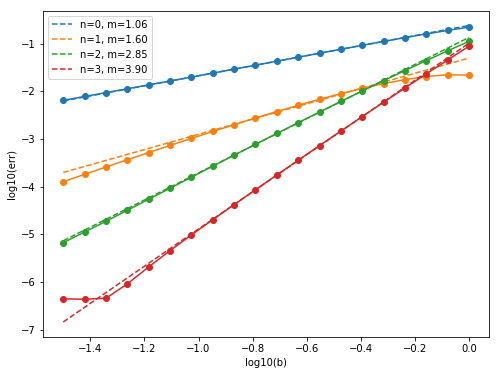

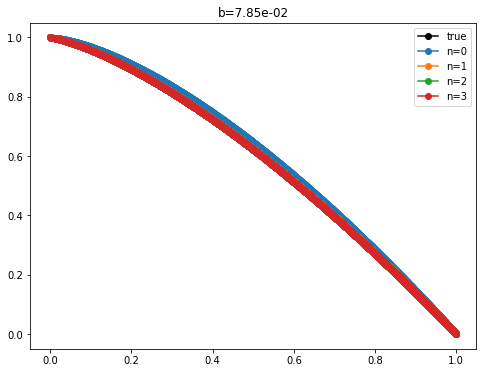

In [88]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['b', 'num_scatters'])

plt.figure(figsize=[8,6])

true_rad_list = []
asym_rad_list = []
i_plot = 5
for num_scatters in num_scatters_list:
    err_list = []
    for i, b in enumerate(b_list):
        results_list = kelp_analyze.query_results(
            conn, study_name,
            b=b,
            num_scatters=num_scatters,
        )
        
        rad = results_list[0]['rad'][:]
        true_rad = results_list[0]['true_rad'][:]

        err = norm(rad - true_rad)
        err_list.append(err)
        
        if i == i_plot:
            asym_rad_list.append(rad)
            true_rad_list.append(true_rad)

    b_arr = np.array(b_list)[:]
    err_arr = np.array(err_list)[:]
    
    print("err arr {}: {}".format(num_scatters, err_arr))
    conv.plot_lin_fit(
        np.log10(b_arr), np.log10(err_arr), 
        min(-1+0*np.log(b_arr)), -.25+0*max(np.log(b_arr)), 
        xlabel='log10(b)', ylabel='log10(err)',
        label='n=%d, m={m:.2f}' % num_scatters
    )
plt.title('')
plt.legend()

plt.figure(figsize=(8,6))
grid = mms.gen_grid(ns, nz, ntheta, nphi, rope_spacing, zmax)
plot_inds = np.zeros_like(grid[2], dtype=bool)
plot_inds[0,0,:,0] = True
z = grid[2][plot_inds]
plt.plot(z, true_rad_list[0][plot_inds], 'ko-', label='true')
for n in num_scatters_list:
    plt.plot(z, asym_rad_list[n][plot_inds], 'C{}o-'.format(n), label='n={}'.format(n))

plt.title('b={:.2e}'.format(b_list[i_plot]))
plt.legend()

Plot Taylor Series Error

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['b', 'num_scatters'])
#this_sol_expr = sp.parsing.sympy_parser.parse_expr(
#    kelp_analyze.table_to_df(conn, study_name)['source_expr'][0], 
#    local_dict={'gamma': sp.Symbol('gamma')}
#)
tay_term_N = mms.gen_series_N(sol_expr, max(num_scatters_list), **param_vals)
def tay_approx_N(x, y, z, theta, phi, b, n):
    s = 0*(x+y+z+theta+phi)
    for k in range(n+1):
        s += b**k * tay_term_N(x, y, z, theta, phi, k)
    
    return s

fig1 = plt.figure(figsize=[8,6])
ax1 = plt.gca()
fig2 = plt.figure(figsize=[8,6])
ax2 = plt.gca()

tay_rad_list = []
true_rad_list = []
i_plot = 6
for num_scatters in num_scatters_list:
    err_list = []
    for i, b in enumerate(b_list):
        results_list = kelp_analyze.query_results(
            conn, study_name,
            b=b,
            num_scatters=num_scatters,
        )

        ns = results_list[0]['ns'][:].data
        nz = results_list[0]['nz'][:].data
        ntheta = results_list[0]['ntheta'][:].data
        nphi = results_list[0]['nphi'][:].data
        grid = mms.gen_grid(ns, nz, ntheta, nphi, rope_spacing, zmax)

        tay_rad = tay_approx_N(*grid, b, num_scatters)
        #rad = results_list[0]['rad'][:]
        true_rad = results_list[0]['true_rad'][:]

        err = norm(tay_rad - true_rad)
        err_list.append(err)
        
        if i == i_plot:
            tay_rad_list.append(tay_rad)
            true_rad_list.append(true_rad)

    b_arr = np.array(b_list)[:-2]
    err_arr = np.array(err_list)[:-2]
    
    print("err arr {}: {}".format(num_scatters, err_arr))
    plt.sca(ax1)
    conv.plot_lin_fit(
        np.log10(b_arr), np.log10(err_arr), 
        min(np.log(b_arr)), 0*max(np.log(b_arr)), 
        xlabel='log10(b)', ylabel='log10(err)',
        label='n=%d, m={m:.2f}' % num_scatters
    )
    
    
plt.sca(ax1)
plt.title('')
plt.legend()


plt.sca(ax2)
z = grid[2][plot_inds]
plt.plot(z, true_rad_list[0][plot_inds], 'ko-', label='true')
for n in num_scatters_list:
    plt.plot(z, tay_rad_list[n][plot_inds], 'C{}o-'.format(n), label='n={}'.format(n))

plt.title('b={:.2e}'.format(b_list[i_plot]))
plt.legend()


In [ ]:
for n in num_scatters_list:
    print("{}: {:.2e}".format(
        n,
        np.abs(asym_rad_list[n] - tay_rad_list[n]).max()
    ))

In [ ]:
import sys

In [ ]:
sorted(((4,6), (5,1), (6,9)), key=lambda x: x[1])

In [ ]:
del(tay_rad)

In [ ]:
ipc = ipp.Client()

In [ ]:
lv = ipc.load_balanced_view()

In [ ]:
def sz():
    import sys
    return sorted([(n, sys.getsizeof(v)/2**30) for n, v in globals().items()], key=lambda t: t[1], reverse=True)

In [ ]:
fut = lv.apply(sz)

In [ ]:
fut.done()